In [172]:
import pandas as pd
import numpy as np
import requests
import re
from Bio import SeqIO
import subprocess
from random import sample
from scipy.stats import entropy

def ko2genes(ko):
    url = 'http://rest.kegg.jp/link/genes/' + ko
    r = requests.get(url)
    geneKO = pd.DataFrame([x.split('\t') for x in r.text.split('\n')],columns=['ko','gene'])
    geneKO = geneKO.iloc[0:-1]
    return geneKO

def download_seqs(geneList,fileName,batchSize):    
    geneList_chunks = [geneList[i * batchSize:(i + 1) * batchSize] for i in range((len(geneList) + batchSize - 1) // batchSize )]
    with open(fileName,'w') as fastafile:
        for sglist in geneList_chunks:
            url =  'http://rest.kegg.jp/get/' + "+".join(sglist) + '/aaseq'
            fseqs = requests.get(url).text
            fastafile.write(fseqs)

            
def msaSeq2df(seq,indexStart):
    idx = []
    resid = []
    j = indexStart;
    for i in seq:
        resid.append(i)
        if i == '-':
            idx.append(np.nan)
        else:
            idx.append(j)
            j = j+1
    
    return pd.DataFrame({'residue': resid, 'index': idx})

def ecogenes():
    url = 'http://rest.kegg.jp/link/ko/eco'
    r = requests.get(url)
    geneKO = pd.DataFrame([x.split('\t') for x in r.text.split('\n')],columns=['gene','ko'])
    geneKO = geneKO.iloc[0:-1]
    return geneKO

get_resid = lambda x: [x for x in re.findall(r'\D',x) if len(x)>0][0]
get_resid_idx = lambda x: [int(x) for x in re.findall(r'\d*',x) if len(x)>0][0]


# load the structural annotations and only keep NAD binding enzymes with single D or E residues 
structure = pd.read_csv('../assets/structure/oxidoreductases_residue_annotation.csv',index_col=0)
#structure = structure[structure['Coenzyme'].isin(['NAD','NADH'])]
#structure = structure[structure['Residues'].apply(lambda x: (len(x.split(';')) < 2) & (x[0] in ['E','D']))]

structure = structure[~structure.Residues.isna() & (structure.Residues != 'None')]
structure = structure[~structure['Homolog-KEGG'].isna()]


In [509]:
# need to repeat for serA
idx = 'b2913'
row = structure.loc[idx]
genes = ko2genes(row.KO)
ecoli_gene = 'eco:' + idx
homolog = row['Homolog-KEGG']
gene_set = list(set([ecoli_gene,homolog]))
gl = genes[~genes['gene'].isin(gene_set)].gene.unique().tolist()
if (len(gl) + len(gene_set)) > seqMax:
    gsample = sample(gl,seqMax-len(gene_set))
    gr = gsample + gene_set
else:
    gr = gl + gene_set
    
download_seqs(gr,'../assets/kegg_seqs_1k_allGenes/' + row.KO + '.fasta',10)

In [510]:
ko = row.KO
    # perform msa on all orthogroups (or subsets of 1k sequences)
fin = '../assets/kegg_seqs_1k_allGenes/' + ko + '.fasta'
fout = '../assets/kegg_seqs_1k_allGenes/msa/' + ko + '.MSA.fasta'
muscle_path = '/Users/joshuagoldford/opt/miniconda3/bin/muscle'
call = muscle_path + ' -in ' + fin + ' -out ' + fout
subprocess.call(call,shell=True)

0

In [40]:
seqMax = 1000
seq_download = []

for idx,row in structure.iterrows():
    genes = ko2genes(row.KO)
    ecoli_gene = 'eco:' + idx
    homolog = row['Homolog-KEGG']
    gene_set = list(set([ecoli_gene,homolog]))
    gl = genes[~genes['gene'].isin(gene_set)].gene.unique().tolist()
    if (len(gl) + len(gene_set)) > seqMax:
        gsample = sample(gl,seqMax-len(gene_set))
        gr = gsample + gene_set
    else:
        gr = gl + gene_set
    
    download_seqs(gr,'../assets/kegg_seqs_1k_allGenes/' + row.KO + '.fasta',10)
    print('finished downloading :' + row.KO + '; num seqs: ' + str(len(gr)))
    seq_download.append(True)

finished downloading :K12524; num seqs: 1000
finished downloading :K00215; num seqs: 1000
finished downloading :K00382; num seqs: 1000
finished downloading :K00099; num seqs: 1000
finished downloading :K00121; num seqs: 1000
finished downloading :K00286; num seqs: 1000
finished downloading :K00077; num seqs: 1000
finished downloading :K01491; num seqs: 1000
finished downloading :K00384; num seqs: 1000
finished downloading :K12972; num seqs: 1000
finished downloading :K00059; num seqs: 1000
finished downloading :K02492; num seqs: 1000
finished downloading :K00208; num seqs: 1000
finished downloading :K03778; num seqs: 1000
finished downloading :K13953; num seqs: 1000
finished downloading :K00027; num seqs: 1000
finished downloading :K16066; num seqs: 1000
finished downloading :K05887; num seqs: 328
finished downloading :K06447; num seqs: 1000
finished downloading :K00262; num seqs: 1000
finished downloading :K00134; num seqs: 1000
finished downloading :K00036; num seqs: 1000
finished do

In [22]:
#structure

In [46]:
# perform MSA using either original KO group sequences or downsample

for idx,row in structure.iterrows():
    ko = row.KO
        # perform msa on all orthogroups (or subsets of 1k sequences)
    fin = '../assets/kegg_seqs_1k_allGenes/' + ko + '.fasta'
    fout = '../assets/kegg_seqs_1k_allGenes/msa/' + ko + '.MSA.fasta'
    muscle_path = '/Users/joshuagoldford/opt/miniconda3/bin/muscle'
    call = muscle_path + ' -in ' + fin + ' -out ' + fout
    subprocess.call(call,shell=True)
    print('finished with mutiple sequence alignment for KO group: ' + ko)

finished with mutiple sequence alignment for KO group: K12524
finished with mutiple sequence alignment for KO group: K00215
finished with mutiple sequence alignment for KO group: K00382
finished with mutiple sequence alignment for KO group: K00099
finished with mutiple sequence alignment for KO group: K00121
finished with mutiple sequence alignment for KO group: K00286
finished with mutiple sequence alignment for KO group: K00077
finished with mutiple sequence alignment for KO group: K01491
finished with mutiple sequence alignment for KO group: K00384
finished with mutiple sequence alignment for KO group: K12972
finished with mutiple sequence alignment for KO group: K00059
finished with mutiple sequence alignment for KO group: K02492
finished with mutiple sequence alignment for KO group: K00208
finished with mutiple sequence alignment for KO group: K03778
finished with mutiple sequence alignment for KO group: K13953
finished with mutiple sequence alignment for KO group: K00027
finished

In [48]:
#structure

In [497]:
structure = pd.read_csv('../assets/structure/residueTable.66genes.csv',index_col=0)


ko_list =  [];
residue_list = []
residue_ref_idx = []
residue_msa_idx = []
count_occured = []
count_not_occured = []
frac_occured = []

dfs = []

for idx,row in structure.iterrows():
    ko = row.KO
    msa_file = '../assets/kegg_seqs_1k_allGenes/msa/' + ko + '.MSA.fasta'
    seq_dict = SeqIO.to_dict(SeqIO.parse(msa_file,'fasta'))
    if structure[structure.KO == ko]['Homolog-KEGG'].tolist()[0] in list(seq_dict):
        seq_id = structure[structure.KO == ko]['Homolog-KEGG'].tolist()[0]
        r = structure[structure.KO == ko].Residues[0].split(';')
        r  = [x for x in r if x not in ['Unclear',None]]
        if len(r) > 0:
            r = pd.DataFrame({'residue': [get_resid(y) for y in r],'index':[get_resid_idx(y) for y in r]})
            seq = str(seq_dict[seq_id].seq)
            seqdf = msaSeq2df(seq,1)
            sdf = seqdf[seqdf['index'].isin(r['index'].tolist())]
            for midx,row2 in sdf.iterrows():
                chars = [y.seq[midx] for y in list(seq_dict.values())]
                
                c = [chars.count(x) for x in list(set(chars))]
                c = [x + 0.5 for x in c]
                pk = np.array(c)/sum(c)
                site_entropy = entropy(pk)
                
                z = pd.DataFrame({'idx':chars}).reset_index().groupby('idx').count()
                z2 = z.reset_index()
                z2.columns = ['residue','numSeqs']
                z2['ref_residue'] = row2.residue
                z2['ref_residue_idx'] = row2['index']
                z2['entropy'] = site_entropy
                z2['KO'] = ko
                dfs.append(z2)
                #frac = z.loc[row2.residue]['index'] / z['index'].sum()
                ##ko_list.append(ko)
                #residue_list.append(row2.residue)
                #residue_ref_idx.append(row2['index'])
                #residue_msa_idx.append(midx)
                #count_occured.append(z.loc[row2.residue]['index'])
                #count_not_occured.append(z['index'].sum() - z.loc[row2.residue]['index'])
                #frac_occured.append(frac)

dfs = pd.concat(dfs,axis=0)                

#r = r[r['wt_residue'].apply(lambda x: x[0] in ['D','E'])]
#results = pd.DataFrame({'ko':ko_list,'residue':residue_list,'idx': residue_ref_idx, 'midx': residue_msa_idx, 'count': count_occured, 'ncount': count_not_occured, 'frac': frac_occured})    

In [203]:
import seaborn as sns

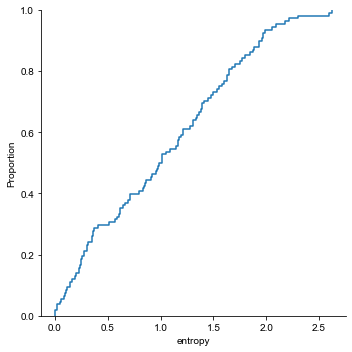

In [499]:
sns.displot(dfs.groupby(['KO','ref_residue_idx']).mean(),kind='ecdf',x='entropy')

In [498]:
se = {'KO':[],'idx':[],'entropy':[],'coenzyme_residue':[]}
for idx,row in structure.iterrows():
    ko = row.KO
    msa_file = '../assets/kegg_seqs_1k_allGenes/msa/' + ko + '.MSA.fasta'
    seq_dict = SeqIO.to_dict(SeqIO.parse(msa_file,'fasta'))
    if structure[structure.KO == ko]['Homolog-KEGG'].tolist()[0] in list(seq_dict):
        seq_id = structure[structure.KO == ko]['Homolog-KEGG'].tolist()[0]
        r = structure[structure.KO == ko].Residues[0].split(';')
        r  = [x for x in r if x not in ['Unclear',None]]
        if len(r) > 0:
            r = pd.DataFrame({'residue': [get_resid(y) for y in r],'index':[get_resid_idx(y) for y in r]})
            seq = str(seq_dict[seq_id].seq)
            seqdf = msaSeq2df(seq,1)
            seqdf['coenzymes_residue' ]= seqdf['index'].isin(r['index'].tolist())
            for midx,row2 in seqdf.iterrows():
                chars = [y.seq[midx] for y in list(seq_dict.values())]
                c = [chars.count(x) for x in list(set(chars))]
                c = [x + 0.5 for x in c]
                pk = np.array(c)/sum(c)
                site_entropy = entropy(pk)
                se['KO'].append(ko); se['idx'].append(midx); se['entropy'].append(site_entropy); 
                se['coenzyme_residue'].append(row2.coenzymes_residue)
se = pd.DataFrame(se)

In [500]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = "Arial"

from matplotlib.pyplot import figure

In [501]:
#sns.catplot(x='KO',y='entropy',hue='coenzyme_residue',data=se)

In [502]:
lethal = ['leuB','pdxB','paaH', 'gatD', 'lgoD', 'fucO','srlD','mltD']

In [503]:
k = structure[structure['gene name'].isin(lethal)].KO.tolist()

In [504]:
structure[structure['gene name'].isin(lethal)]

,gene name,uniprot,KO,Redundancy,Unique oxidoreductase reactions,iJO1344-reactions,Structure,Coenzyme Bound Structure,Homolog-Species,Homolog-KEGG,Homolog-Uniprot,Residues,Coenzyme,% Identity,Notes
gene id,,,,,,,,,,,,,,,
b2320,pdxB,P05459,K03473,NaN,PERD,PERD,None,3OET,Salmonella enterica subsp. enterica serovar Ty...,stm:STM2370,P60802,D146,NAD,88.7,NAD
b0073,leuB,P30125,K00052,NaN,IPMD,IPMD,1CM7,4XXV,Burkholderia thailandensis,bte:BTH_II0674,Q2T7H6,D284,NAD,50.5,NaN
b2799,fucO,P0A9S1,K00048,NaN,LCARS,NaN,"5BR4,1RRM,2BL4,2BI4",2BL4,Esherichia coli K12,eco:b2799,P0A9S1,D38,NAD,NaN,NaN


In [269]:
structure.to_csv('../assets/structure/residueTable.66genes.csv')

Text(0.5, 6.799999999999994, 'residue entropy')

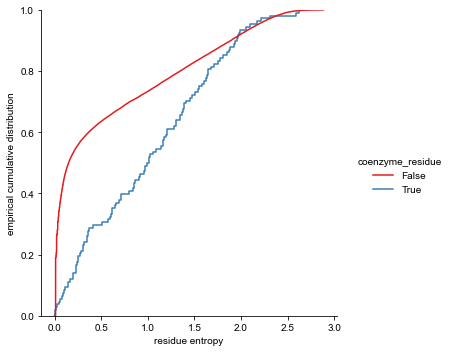

In [505]:
sns.displot(se,kind='ecdf',x='entropy',hue='coenzyme_residue',palette='Set1')
plt.ylabel('empirical cumulative distribution')
plt.xlabel('residue entropy')
#plt.savefig('siteEntropy.svg')

In [223]:
se[~se['coenzyme_residue']]['entropy'].median()

0.15093012223931346

In [225]:
from scipy.stats import ranksums

In [506]:
x = se[se['coenzyme_residue']]['entropy'].values
y = se[~se['coenzyme_residue']]['entropy'].values
ranksums(x,y)

RanksumsResult(statistic=7.36007707839984, pvalue=1.838040664822833e-13)

In [247]:
len(y)

63084

In [182]:
c = [chars.count(x) for x in list(set(chars))]
c = [x + 0.5 for x in c]
pk = np.array(c)/sum(c)
site_entropy = entropy(pk)

In [493]:
structure = pd.read_csv('../assets/structure/residueTable.66genes.csv',index_col=0)
# iterate through structure to find if residues match database
database_checked = []
for idx,row in structure.iterrows():
    ko = row.KO
    msa_file = '../assets/kegg_seqs_1k_allGenes/msa/' + ko + '.MSA.fasta'
    seq_dict = SeqIO.to_dict(SeqIO.parse(msa_file,'fasta'))
    if structure[structure.KO == ko]['Homolog-KEGG'].tolist()[0] in list(seq_dict):
        seq_id = structure[structure.KO == ko]['Homolog-KEGG'].tolist()[0]
        r = structure[structure.KO == ko].Residues[0].split(';')
        r  = [x for x in r if x not in ['Unclear',None]]
        if len(r) > 0:
            r = pd.DataFrame({'residue': [get_resid(y) for y in r],'index':[get_resid_idx(y) for y in r]})
            seq = str(seq_dict[seq_id].seq)
            seqdf = msaSeq2df(seq,1)
            sdf = seqdf[seqdf['index'].isin(r['index'].tolist())]
            
            msa_seq_residues = sdf['residue'] + '_' + sdf['index'].apply(lambda x: str(round(x)))
            database_residues = r['residue'] + '_' + r['index'].apply(lambda x: str(round(x)))
            database_residues= database_residues.tolist()
            msa_seq_residues = msa_seq_residues.tolist()
            if set(msa_seq_residues) == set(database_residues):
                database_checked.append(True)
            else:
                database_checked.append(False)

        else:
            database_checked.append(True)
    else:
        database_checked.append(True)
#r = r[r['wt_residue'].apply(lambda x: x[0] in ['D','E'])]
#results = pd.DataFrame({'ko':ko_list,'residue':residue_list,'idx': residue_ref_idx, 'midx': residue_msa_idx, 'count': count_occured, 'ncount': count_not_occured, 'frac': frac_occured})    

In [494]:
structure['residue_check'] = database_checked

In [496]:
structure

,gene name,uniprot,KO,Redundancy,Unique oxidoreductase reactions,iJO1344-reactions,Structure,Coenzyme Bound Structure,Homolog-Species,Homolog-KEGG,Homolog-Uniprot,Residues,Coenzyme,% Identity,Notes,residue_check
gene id,,,,,,,,,,,,,,,,
b0002,thrA,P00561,K12524,Not unique,NaN,NaN,6MX1,6DZS,Mycolicibacterium hassiacum DSM 44199,has:MHAS_02717,K5BJC9,R50;R51;R56,NADP,NaN,hom;,True
b0031,dapB,P04036,K00215,NaN,DHDPRy,DHDPRy,1ARZ,1ARZ,Esherichia coli K12,eco:b0031,P04036,E38,NAD,100,dapB,True
b0116,lpdA,P0A9P0,K00382,NaN,AKGDH;GLYCL;PDH,AKGDH;GLYCL;PDH,4JDR,1LVL,Psuedomonas putida,ppu:PP_4404,P09063,E202,NAD,NaN,lpdV (structural is from different strain),True
b0173,dxr,P45568,K00099,NaN,DXPRIi,DXPRIi,3ANL,3ANL,Esherichia coli K12,eco:b0173,P45568,T10;N38;K37,NADPH,100,Binding through peptide backbone,True
b0356,frmA,P25437,K00121,NaN,ALCD19;FALDH2,ALCD19;FALDH2,None,3UKO,Arabidopsis thaliana,ath:AT5G43940,Q96533,D226,NAD,59.1,NADH bound,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b3575,yiaK,P37672,K08092,NaN,DOGULNR,NaN,"1NXU,1S20",1S20,Esherichia coli K12,eco:b3575,P37672,E306,NAD,NaN,NaN,True
b3924,fpr,P28861,K00528,NaN,FLDR2,NaN,"1FDR,2XNJ",2XNJ,Esherichia coli K12,eco:b3924,P28861,S173;R174;R184,NADP,NaN,NaN,True
b3941,metF,P0AEZ1,K00297,NaN,MTHFR2,NaN,"3FST,3FSU,1ZP3,1ZP4,1ZPT,2FMN,1ZRQ,2FMO,1B5T,6PEY",1ZP4,Esherichia coli K12,eco:b3941,P0AEZ1,T59,NADH,NaN,L277 could exclused phosphate on 2' hydroxyl f...,True


In [344]:
set(msa_seq_residues) == set(database_residues)

True

In [343]:
list(set(msa_seq_residues).intersection(set(database_residues)))

['K_41', 'R_37', 'N_36', 'S_38']

In [156]:
results = {'KO':[],'coenzymes':[],'ridx':[],'ref_residue':[],'frac':[]}
for (ko,ridx), dff in dfs.groupby(['KO','ref_residue_idx']):
    
    coenzymes = structure[structure.KO == ko]['Coenzyme'].dropna().tolist()
    ref_residue = dff['ref_residue'].unique()[0]
    tp = dff[dff['residue'] == ref_residue].numSeqs.values[0]
    fp = dff[dff['residue'] != ref_residue].numSeqs.values.sum()
    frac = tp/(tp+fp)
    results['KO'].append(ko); 
    results['ridx'].append(ridx); 
    results['ref_residue'].append(ref_residue);
    results['frac'].append(frac)
    results['coenzymes'].append(";".join(coenzymes))
    
results = pd.DataFrame(results)

In [162]:
sdf

,residue,index
261,L,59.0


In [55]:
dfs_new = pd.concat(dfs_new,axis=0)
dfs_new = dfs_new[dfs_new['ref_residue'].isin(['D','E'])]
prop = dfs_new.pivot_table(index='KO',columns = ['residue'],values='proportion').fillna(0).T
p = prop.T.join(structure.reset_index()[['KO','gene name']].set_index('KO')).reset_index()
p['id'] = p['gene name'] + ' (' + p['KO'] + ')'
p.set_index(['KO','gene name'],inplace=True)
p.set_index('id',inplace=True)


In [70]:
mean_rgr = dfst_normalized[[x for x in list(p.T) if x in list(dfst_normalized)]].min().sort_values()

In [71]:
conservation = p['E'] + p['D']

In [72]:
mean_rgr

leuB (K00052)    0.000000
pdxB (K03473)    0.000000
gapA (K00134)    0.000401
mdh (K00024)     0.006426
frmA (K00121)    0.734684
tdh (K00060)     0.997261
rfbD (K00067)    0.999998
wecC (K02472)    0.999998
astD (K06447)    0.999998
ugd (K00012)     0.999998
dapB (K00215)    0.999998
maeA (K00027)    0.999998
hisD (K00013)    0.999998
dtype: float64

In [132]:
cpr = pd.DataFrame(conservation,columns = ['conservation']).join(pd.DataFrame(mean_rgr,columns=['mean growth rate'])).dropna()

In [83]:
gs = pd.read_csv('../assets/mutantGeneSet.reactionDirectionUpdateRules.MR4.csv')

In [125]:
ids['gene id'] = ids['gene id'].apply(lambda x: x.strip())

In [129]:
nad_genes = gs[gs['wild type coenzyme'].isin(['NAD(H)'])].gene.tolist()

In [131]:
ids[ids['gene id'].isin(nad_genes)].id.tolist()

['lpdA (K00382)',
 'frmA (K00121)',
 'maeA (K00027)',
 'astD (K06447)',
 'gapA (K00134)',
 'hisD (K00013)',
 'ugd (K00012)',
 'pdxB (K03473)',
 'mdh (K00024)',
 'tdh (K00060)',
 'wecC (K02472)',
 'leuB (K00052)',
 'allD (K00073)',
 'dmlA (K07246)',
 'tyrA (K14187)',
 'fucO (K00048)',
 'yiaK (K08092)']

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt


def label_point(x, y, val, ax):
    a = pd.DataFrame({'x': x, 'y': y, 'val': val})
    for i, point in a.iterrows():
        ax.text(point['x']+.002, point['y'], point['val'])
        
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

In [133]:
idl = ids[ids['gene id'].isin(nad_genes)].id.tolist()
cpr = cpr.reset_index()
cpr_nad = cpr[cpr.id.isin(idl)]

In [134]:
cpr_nad.sort_values('mean growth rate')

,id,conservation,mean growth rate
4,leuB (K00052),0.937,0.000000
11,pdxB (K03473),1.000,0.000000
8,gapA (K00134),0.881,0.000401
2,mdh (K00024),0.975,0.006426
7,frmA (K00121),0.996,0.734684
5,tdh (K00060),0.993,0.997261
10,wecC (K02472),0.965,0.999998
12,astD (K06447),0.997,0.999998
0,ugd (K00012),0.973,0.999998
3,maeA (K00027),0.938,0.999998


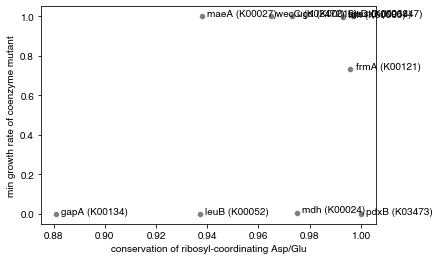

In [135]:

ax = sns.scatterplot(x='conservation',y='mean growth rate',data=cpr_nad,color='grey')
label_point(cpr_nad['conservation'].tolist(),cpr_nad['mean growth rate'].tolist(),cpr_nad['id'].tolist(),ax)
plt.xlabel('conservation of ribosyl-coordinating Asp/Glu')
plt.ylabel('min growth rate of coenzyme mutant')
plt.savefig('orthogroups.DE.conservation.Vs.GrowthRate.svg')

In [139]:
p.loc[idl]

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Index(['lpdA (K00382)', 'allD (K00073)', 'dmlA (K07246)', 'tyrA (K14187)',\n       'fucO (K00048)', 'yiaK (K08092)'],\n      dtype='object', name='id'). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

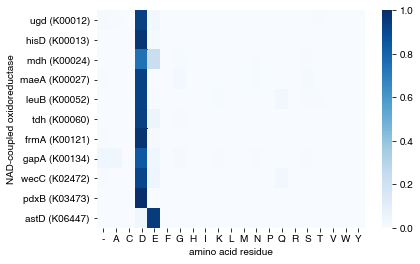

In [158]:
sns.heatmap(p.reset_index()[p.reset_index().id.isin(idl)].set_index('id'),cmap="Blues")
plt.xlabel('amino acid residue')
plt.ylabel('NAD-coupled oxidoreductase')
plt.savefig('orthogroups.DE.conservation.heatmap.svg')

In [1]:
len('YDRTVGIVGVGNVGRRLQARLEALGIKTLLCDPPRADRGDEG')

42